こちらを回してみる

https://github.com/globality-corp/sklearn-hierarchical-classification/blob/develop/examples/classify_digits.py

In [1]:
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn_hierarchical_classification.tests.fixtures import make_digits_dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}

# Used for seeding random state
RANDOM_STATE = 42

In [2]:
"""Test that a nontrivial hierarchy leaf classification behaves as expected.
    We build the following class hierarchy along with data from the handwritten digits dataset:
            <ROOT>
           /      \
          A        B
         / \       |  \
        1   7      C   9
                 /   \
                3     8
"""
# define hierarchy
class_hierarchy = {
        ROOT: ["A", "B"],
        "A": ["1", "7"],
        "B": ["C", "9"],
        "C": ["3", "8"],
    }

In [3]:
X, y = make_digits_dataset(
        targets=[1, 7, 3, 8, 9],
        as_str=False,)
# cast the targets to strings so we have consistent typing of labels across hierarchy
y = y.astype(str)
X.shape,y.shape #MNIST

((898, 64), (898,))

In [4]:
# split for evaluation
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=RANDOM_STATE,)

['7' '3' '7' '1' '1']


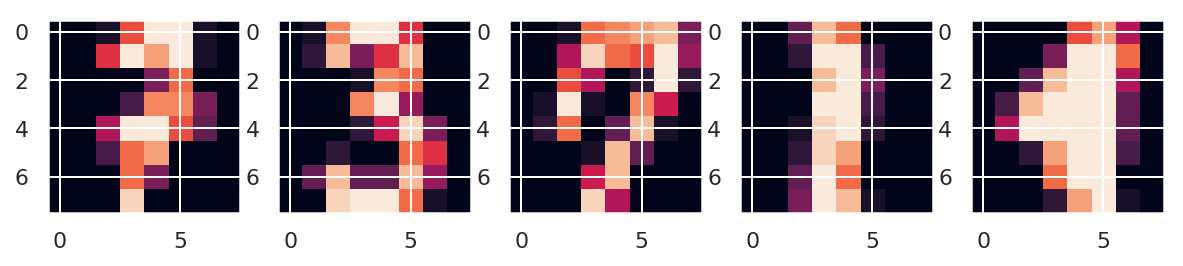

In [5]:
plt.figure(figsize=[10,5])
print(y_train[:5])
for i,x in enumerate(X_train[:5]):
    plt.subplot(1,5,i+1)
    plt.imshow(x.reshape(8,8))

In [6]:
base_estimator = make_pipeline(
        TruncatedSVD(n_components=24),
        svm.SVC(
            gamma=0.001,
            kernel="rbf",
            probability=True
        ),
    )
clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    progress_wrapper=tqdm
)

In [7]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred[:5]

Training base classifiers: 100%|██████████| 9/9 [00:00<00:00, 23.23it/s]


masked_array(data=['8', '9', '8', '9', '3'],
             mask=False,
       fill_value='N',
            dtype='<U1')

In [8]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        41
           7       1.00      1.00      1.00        30
           8       0.97      1.00      0.99        36
           9       1.00      0.97      0.99        36

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



In [9]:
# Demonstrate using our hierarchical metrics module with MLB wrapper
with multi_labeled(y_test, y_pred, clf.graph_) as (y_test_, y_pred_, graph_):
    h_fbeta = h_fbeta_score(
        y_test_,
        y_pred_,
        graph_,
    )
print("h_fbeta_score: ", h_fbeta)

h_fbeta_score:  0.9965714285714286


In [10]:
multi_labeled(y_test, y_pred, clf.graph_)

In [11]:
clf.graph_.adj

AdjacencyView({'<ROOT>': {'A': {}, 'B': {}}, 'A': {'1': {}, '7': {}}, 'B': {'C': {}, '9': {}}, 'C': {'3': {}, '8': {}}, '1': {}, '7': {}, '9': {}, '3': {}, '8': {}})

In [12]:
print(y_pred_.shape) # 8 means graph_ has 8 node
y_pred_[14] # notmultilabel just one-hot

(180, 8)


array([0, 0, 0, 0, 1, 0, 0, 0])